In [840]:
import requests
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from numpy import log
import scipy.optimize as spo
def sird(x, gamma=1, eta=1, beta=1):
    return gamma*(1 - np.exp(- eta * x)) - beta*x
def sid(x, gamma=1, eta=1):
    return gamma*(1 - np.exp(- eta * x)) - gamma*x
def gomp(x, beta=1, alpha=1, x_tilde=1):
    return beta*x - alpha*x*np.log((x + 0.0001) / x_tilde)
def gomp_time(t, x0, beta, alpha, x_tilde):
    xinf = x_tilde * np.exp(beta / alpha)
    gamma = x0 / xinf
    return xinf * np.power(gamma, np.exp(- alpha * t))
def gomp_norm(lns, alpha):
    return - alpha * lns

def sirdODE(t, y, r, a, d):
    S, I, R, D = y
    Sp = -r * S * I
    Ip = r * S * I - (a + d) * I
    Rp = a * I
    Dp = d * I
    yp = Sp, Ip, Rp, Dp
    return yp

def sird_time(t, x0, s0, gamma, eta, beta):
    y0 = s0, x0, 0, 0
    tmax = np.max(t)
    d, r = gamma/s0, eta * gamma
    a = beta - d
    print(d,a,r)
    
    obj = integrate.solve_ivp(sirdODE, (0, tmax), y0, 
                              t_eval=np.arange(tmax + 1), args=(r, a, d))
#     d_sird_norm = obj["y"][3, :] / obj["y"][3, :].max()
    d_sird = obj["y"][3, :] / obj["y"][3, :].max()
    return d_sird

def safe_lnln(x, k=1):
    z = x / k
    eps = 1e-5
    z[z == 0] = eps
    z[z >= 1.] = 1- eps
    return np.log(-np.log(z))

In [134]:
# Extract data from ECDC: https://www.ecdc.europa.eu/en/publications-data/data-daily-new-cases-covid-19-eueea-country
url = "https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv/data.csv"
# Extract from https://github.com/CSSEGISandData/COVID-19
url2 = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [135]:
data2 = pd.read_csv(url2)
data2.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/22,3/7/22,3/8/22,3/9/22,3/10/22,3/11/22,3/12/22,3/13/22,3/14/22,3/15/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7623,7626,7630,7636,7639,7640,7641,7643,7645,7646
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,3482,3483,3483,3483,3484,3485,3485,3485,3485,3486
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,6855,6857,6858,6860,6861,6861,6862,6864,6866,6868
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,151,151,152,152,152,152,152,152,152,152
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,1900,1900,1900,1900,1900,1900,1900,1900,1900,1900


In [ ]:
data = pd.read_csv(url)
data.head()

In [29]:
data.dateRep.tail(100)

22182    13/05/2020
22183    12/05/2020
22184    11/05/2020
22185    10/05/2020
22186    09/05/2020
            ...    
22277    08/02/2020
22278    07/02/2020
22279    06/02/2020
22280    05/02/2020
22281    04/02/2020
Name: dateRep, Length: 100, dtype: object

In [117]:
# Process data
countries = data.countriesAndTerritories.unique()
countries

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden'], dtype=object)

In [182]:
data2["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [347]:
START_DATE = "2020-01-22"
END_DATE = "2020-05-16"
WINDOW = 7 # days
def get_data2(country):
    y = data2[data2["Country/Region"] == country].iloc[:, 4:].sum(axis=0)
    dates = pd.to_datetime(data2.columns[4:], format="%m/%d/%y")
    cumdeaths = pd.Series(index=dates[1:], data=y.values.flatten()[1:])
    deaths = pd.Series(index=dates[1:], data=np.diff(y.values.flatten()))
    if country == "China":
        deaths = deaths[~((deaths > 1000))]
    cumdeaths = deaths.cumsum()
    deaths = deaths.rolling(WINDOW, center=True).mean()
    country = pd.DataFrame(index=dates[1:], data={"rollDeaths": deaths, "cumDeaths": cumdeaths})
    country = country[START_DATE:END_DATE]
    country = country.dropna()
    return country

def get_data(country: str):

    country = data[data.countriesAndTerritories == country]
    country.index = pd.to_datetime(country.dateRep, format="%d/%m/%Y")
    country = country.sort_index()
    country = country[START_DATE:END_DATE]
    country["rollDeaths"] = country.deaths.rolling(WINDOW, center=True).mean()
    country["cumDeaths"] = country.rollDeaths.cumsum()
    country["rollDeathsNorm"] = country["rollDeaths"] / country["cumDeaths"].max()
    country["cumDeathsNorm"] = country["cumDeaths"] / country["cumDeaths"].max()
    country = country.dropna()
    return country

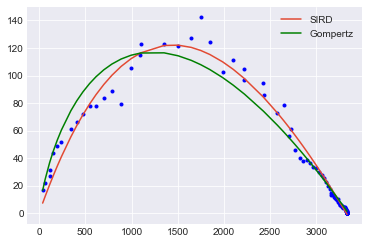

In [348]:
plt.style.use('seaborn-darkgrid')
country_data = get_data2("China")
x, y = country_data.cumDeaths, country_data.rollDeaths
sird_min_params = (10, 1e-6, 0.001) # gamma, eta, beta
sird_max_params = (10000, 1e-2, 1)
gomp_min_params = (0.01, 0.001, 0.01) # beta, alpha, x_tilde
gomp_max_params = (10, 1., 1.)


popt, pcov = spo.curve_fit(sird, x, y, bounds=(sird_min_params, sird_max_params))
popt_gomp, pcov_gomp = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))

plt.plot(x, y, ".", color="#0000ff")
plt.plot(x, sird(x, *popt), label="SIRD")
plt.plot(x, gomp(x, *popt_gomp), label="Gompertz", color="#008000")
plt.legend()

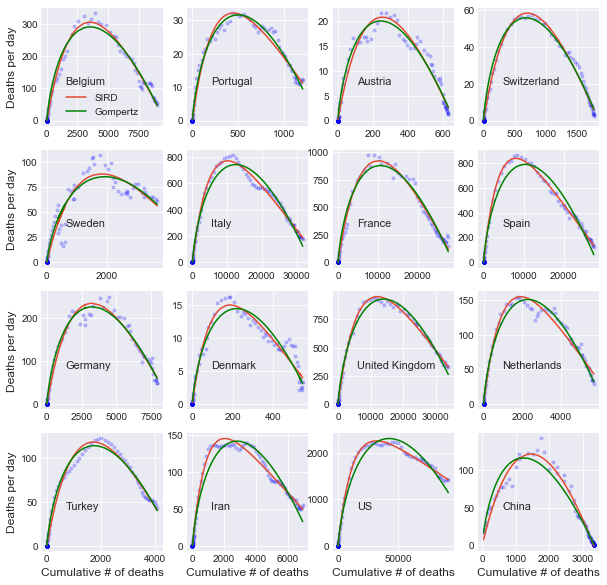

In [847]:
plt.rcParams['text.usetex'] = False
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria', 
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]

popt_country = {}
popt_gomp_country = {}
maxd = {}
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    sird_min_params = (10, 1e-6, 0.001) # gamma, eta, beta
    sird_max_params = (10000, 1e-2, 1)
    gomp_min_params = (0.01, 0.001, 0.01) # beta, alpha, x_tilde
    gomp_max_params = (10, 1., 1.)


    popt, pcov = spo.curve_fit(sird, x, y, bounds=(sird_min_params, sird_max_params))
    popt_gomp, pcov_gomp = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))
    popt_country[country] = popt
    popt_gomp_country[country] = popt_gomp
    gamma, eta, beta = popt
    r0 = np.round(eta * gamma / beta, 1)
    plt.plot(x, y, ".", color="#0000ff", alpha=0.2)
    plt.plot(x, sird(x, *popt), label="SIRD")
    plt.plot(x, gomp(x, *popt_gomp), label="Gompertz", color="#008000")
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.80
    y_alpha = 0.65
    
    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc, country, fontsize=11)
#     plt.text(xloc, yloc * 0.5, r0, fontsize=11)
    if j == 0:
        plt.ylabel("Deaths per day")
    if i == 3:
        plt.xlabel("Cumulative # of deaths")
    if n == 0:
        plt.legend()
plt.savefig("../figures/Gompertz_vs_SIRD.pdf")

0.009055902374440148 0.07309463724368559 0.30235625792576715
0.005005777106201459 0.03536883349633297 0.24097551982879065
0.010360259276132381 0.08321193362543845 0.2947847230037352
0.010242335770332128 0.08341865959140692 0.2986196469519902
0.005266807521626354 0.029650756579447653 0.16344154562634763
0.00411140276131588 0.0311016991874577 0.255343172326186
0.007802313905413501 0.06450242108912405 0.3103779146641279
0.00498526267122369 0.03993227302357148 0.3524373907010619
0.007582682413955136 0.05782197010637056 0.24968764337111968
0.0047749338048841145 0.03526475898002271 0.2794499881616425
0.004981281383562389 0.03490320855435221 0.2650643636170211
0.004776419615796959 0.035195503622379734 0.2714200612848728
0.007359428388272429 0.053410122668566644 0.23602550194923078
0.0030954375509681773 0.02064834258890233 0.2476578965022023
0.003284244478278432 0.01408672468637807 0.25290688050164484
0.024031185259996157 0.16760824939300142 0.3823740798780297


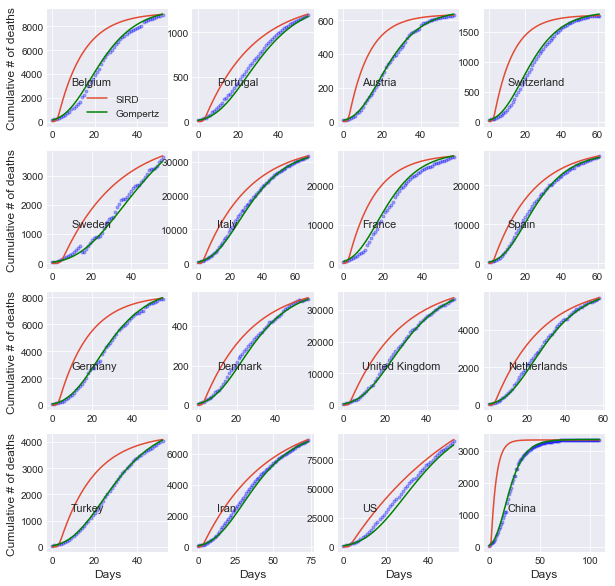

In [855]:
plt.rcParams['text.usetex'] = False
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria', 
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]

inflation = 10
popt_gomp = {}
popt = {}
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    x, y = x / np.max(x), y / np.max(x)
    t0 = min(np.arange(len(x))[x/x.max() > 0.01])
    x, y = x[t0:], y[t0:] 
    t = np.arange(np.maximum(50, len(x) - 1))
    popt[country], pcov = spo.curve_fit(sird, x, y)
    popt_gomp[country], pcov_gomp = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))
    gamma, eta, beta = popt_country[country]
    s0 = np.max(x) * inflation # We need this assumption for SIRD

    plt.plot(t, maxd[country] * x[t], ".", color="#0000ff", alpha=0.3)
    plt.plot(t, maxd[country] * sird_time(t, x[0], s0, *popt[country]), label="SIRD")
    plt.plot(t, maxd[country] * gomp_time(t, x[0], *popt_gomp[country]), label="Gompertz", color="#008000")
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.80
    y_alpha = 0.65

    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc, country, fontsize=11)
#     plt.text(xloc, yloc * 0.5, r0, fontsize=11)
    if j == 0:
        plt.ylabel("Cumulative # of deaths")
    if i == 3:
        plt.xlabel("Days")
    if n == 0:
        plt.legend()
plt.savefig("../figures/Gompertz_vs_SIRD_time.pdf")

0.018111804748880297 0.06403873486924544 0.30235625792576715
0.010011554212402919 0.03036305639013151 0.24097551982879065
0.020720518552264762 0.07285167434930606 0.2947847230037352
0.020484671540664256 0.07317632382107478 0.2986196469519902
0.010533615043252708 0.0243839490578213 0.16344154562634763
0.00822280552263176 0.026990296426141817 0.255343172326186
0.015604627810827002 0.056700107183710546 0.3103779146641279
0.00997052534244738 0.03494701035234779 0.3524373907010619
0.015165364827910272 0.050239287692415424 0.24968764337111968
0.009549867609768229 0.030489825175138593 0.2794499881616425
0.009962562767124778 0.029921927170789817 0.2650643636170211
0.009552839231593918 0.030419084006582775 0.2714200612848728
0.014718856776544859 0.046050694280294215 0.23602550194923078
0.0061908751019363545 0.017552905037934153 0.2476578965022023
0.006568488956556864 0.01080248020809964 0.25290688050164484
0.04806237051999231 0.14357706413300525 0.3823740798780297


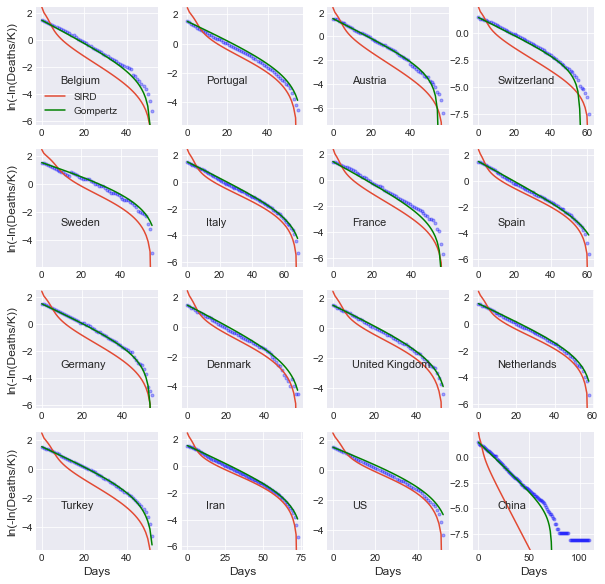

In [854]:
plt.rcParams['text.usetex'] = False
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria', 
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]

inflation = 5
popt_gomp = {}
popt = {}
for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    country_data = get_data2(country)
    x, y = country_data.cumDeaths + 1, country_data.rollDeaths
    maxd[country] = np.max(x)
    x, y = x / np.max(x), y / np.max(x)
    t0 = min(np.arange(len(x))[x/x.max() > 0.01])
    x, y = x[t0:], y[t0:] 
    t = np.arange(np.maximum(50, len(x) - 1))
    popt[country], pcov = spo.curve_fit(sird, x, y)
    popt_gomp[country], pcov_gomp = spo.curve_fit(gomp, x, y, bounds=(gomp_min_params, gomp_max_params))
    gamma, eta, beta = popt_country[country]
    s0 = np.max(x) * inflation # We need this assumption for SIRD
    
    ll = safe_lnln(x[t])
    plt.plot(t, ll, ".", color="#0000ff", alpha=0.3)
    plt.plot(t, safe_lnln(sird_time(t, x[0], s0, *popt[country])), label="SIRD")
    plt.plot(t, safe_lnln(gomp_time(t, x[0], *popt_gomp[country])), label="Gompertz", color="#008000")
    axs[i, j].set_ylim((np.min(ll) - 1, np.max(ll) + 1))
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.80
    y_alpha = 0.65

    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc, country, fontsize=11)
#     plt.text(xloc, yloc * 0.5, r0, fontsize=11)
    if j == 0:
        plt.ylabel("ln(-ln(Deaths/K))")
    if i == 3:
        plt.xlabel("Days")
    if n == 0:
        plt.legend()
plt.savefig("../figures/Gompertz_vs_SIRD_lnln.pdf")

In [853]:
np.min(ll)

-8.111177924494497

In [838]:
# safe_lnln(sird_time(t, x[0], s0, *popt["US"]))
gomp_time(t, x[0], *popt_gomp["Belgium"])

array([0.0120048 , 0.01711995, 0.02373847, 0.03207529, 0.04231993,
       0.05462537, 0.06909913, 0.08579727, 0.1047216 , 0.12581995,
       0.14898934, 0.17408143, 0.20090967, 0.22925756, 0.25888723,
       0.28954806, 0.32098466, 0.35294403, 0.38518168, 0.41746659,
       0.449585  , 0.48134311, 0.51256874, 0.54311212, 0.57284588,
       0.60166454, 0.62948342, 0.65623729, 0.68187873, 0.70637642,
       0.72971335, 0.75188498, 0.77289755, 0.79276642, 0.81151455,
       0.82917107, 0.84577004, 0.8613493 , 0.87594949, 0.88961318,
       0.90238411, 0.9143066 , 0.92542495, 0.93578307, 0.94542407,
       0.95439004, 0.96272172, 0.97045845, 0.97763797, 0.98429635,
       0.99046797, 0.99618545, 1.00147972, 1.00637993, 1.01091361,
       1.01510661, 1.0189832 , 1.02256614, 1.02587671, 1.02893479,
       1.03175896, 1.03436652, 1.03677357, 1.03899511, 1.04104507,
       1.0429364 , 1.04468112, 1.04629035, 1.04777445, 1.04914297,
       1.05040479, 1.0515681 , 1.0526405 , 1.05362901, 1.05454

In [832]:
safe_lnln(sird_time(t, x[0], s0, *popt["Belgium"]))

0.018111804748880297 0.06403873486924544 0.30235625792576715


array([  2.44347036,   2.04594547,   1.80944028,   1.54700834,
         1.24691023,   0.94550825,   0.68520478,   0.46986961,
         0.28715101,   0.12643299,  -0.0190586 ,  -0.15355111,
        -0.27977734,  -0.39958458,  -0.51427473,  -0.62479896,
        -0.73187326,  -0.83605074,  -0.93776736,  -1.03737337,
        -1.13515574,  -1.23134826,  -1.32614814,  -1.4197258 ,
        -1.51222921,  -1.60376823,  -1.69444141,  -1.78434182,
        -1.87355781,  -1.96219249,  -2.05040468,  -2.13819367,
        -2.22553589,  -2.31241255,  -2.39881431,  -2.48474665,
        -2.57023621,  -2.65533791,  -2.74014315,  -2.82478909,
        -2.90946787,  -2.9942362 ,  -3.07898894,  -3.16365718,
        -3.24817611,  -3.33248947,  -3.41655496,  -3.50035087,
        -3.58388393,  -3.66719863,  -3.75038809,  -3.83360678,
        -3.91708561,  -4.00092471,  -4.08492508,  -4.16901144,
        -4.25311356,  -4.33716952,  -4.42113096,  -4.50496952,
        -4.58868464,  -4.67231274,  -4.75593814,  -4.83

/Users/matzhaugen/.pyenv/versions/3.9.4/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/matzhaugen/.pyenv/versions/3.9.4/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/matzhaugen/.pyenv/versions/3.9.4/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/matzhaugen/.pyenv/versions/3.9.4/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/matzhaugen/.pyenv/versions/3.9.4/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/matzhaugen/.pyenv/

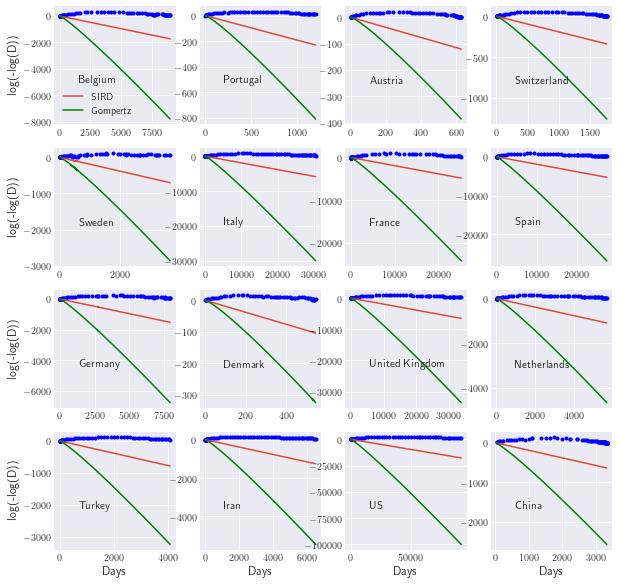

In [720]:
# Plot log lines
plt.rcParams['text.usetex'] = False
f, axs = plt.subplots(4,4,figsize=(10,10))
subset = ['Belgium', 'Portugal',  'Austria', 
       'Switzerland', 'Sweden',  'Italy', 'France', 'Spain', 'Germany','Denmark', 
          "United Kingdom", 'Netherlands', "Turkey", "Iran", "US", "China"]
popt_country = {}
popt_gomp_country = {}
x0 = {}

for n, country in enumerate(subset):
    if n > 15:
        break
    i = int(n / 4)
    j = n % 4
    plt.sca(axs[i, j])
    
    # Get data and crop observations before deaths started rising and after 80 days of the pandemic
    duration = 80 # days, first days of pandemic
    fit_duration = 50
    country_data = get_data2(country)
    maxx = country_data.cumDeaths.max() + 1
    xfull, yfull = (country_data.cumDeaths + 1), country_data.rollDeaths
    t_start = np.min(np.arange(len(xfull))[xfull > 1])
    x0[country] = xfull[t_start]
    x = xfull[t_start:(t_start + duration)]
    y = yfull[t_start:(t_start + duration)]
    t = np.arange(len(x))
    ln = safe_lnln(x.values, maxx)
    
    # Fit Gompertz and SIRD
#     sird_min_params = (0.1, 1e-6, 0.001) # gamma, eta, beta
#     sird_max_params = (100, .1, 1)
    gomp_min_params = (0.01, 0.001, 0.01) # beta, alpha, x_tilde
    gomp_max_params = (10, 1., 1.)
    popt_gomp_country[country], pcov_gomp = spo.curve_fit(gomp, x[:fit_duration], y[:fit_duration], bounds=(gomp_min_params, gomp_max_params))    
    popt_country[country], pcov = spo.curve_fit(sird, xfull, yfull)
    
    # Get evolution of deaths vs. time
    # To do this we need to assume in the SIRD that the susceptible population
    # represents some fraction of the total population, we use 10 as the factor here.
    infl = 5
    beta, alpha, x_tilde = popt_gomp_country[country]
    xinf = x_tilde * np.exp(beta / alpha)
    gamma, eta, beta = popt_country[country]
    s0 = infl * xinf # assumption
    d, r, a = gamma/s0, eta * gamma, beta - d
    y0 = 1, x0[country], 0, 0
    tmax = 80
    obj = integrate.solve_ivp(sirdODE, (0, tmax), y0, 
                              t_eval=np.arange(tmax), args=(r, a, d))
    d_sird_norm = obj["y"][3, :] / obj["y"][3, :].max()
    # Gompertz is already normalized but we need to use the initial death instead of initial suscpetible

    d_gomp_norm = gomp_time(obj["t"], x0[country]/infl, *popt_gomp_country[country])
   
    # Plot
#     plt.plot(obj["t"], safe_lnln(d_sird_norm))
#     plt.plot(obj["t"], safe_lnln(d_gomp))
#     plt.plot(t, ln, ".", color="#0000ff")
    plt.plot(x, y, ".", color="#0000ff")
    plt.plot(x, sird(x, *popt), label="SIRD")
    plt.plot(x, gomp(x, *popt_gomp), label="Gompertz", color="#008000")
    xmin, xmax = axs[i, j].get_xlim()
    ymin, ymax = axs[i, j].get_ylim()
    x_alpha = 0.80
    y_alpha = 0.65
    
    xloc = xmin * x_alpha + xmax * (1-x_alpha)
    yloc = ymin * y_alpha + ymax * (1-y_alpha)
    plt.text(xloc, yloc, country, fontsize=11)
#     plt.text(xloc, yloc * 0.5, r0, fontsize=11)
    if j == 0:
#         plt.ylabel(r'$\ln{(-\ln{D})}$')
        plt.ylabel("log(-log(D))")
    if i == 3:
        plt.xlabel("Days")
    if n == 0:
        plt.legend()
# plt.savefig("../figures/Gompertz_vs_SIRD.pdf")

In [721]:
xinf

3410.0908986761983

In [728]:
gamma, eta, beta = popt_country["Belgium"]
d, r, a = gamma / xinf * 10, eta * gamma, beta - d
d, r, a

(2.3848321252264455, 0.3025288104761377, -2.3029026127358914)

In [691]:
infl = 10
# for c in subset:
for c in ["Belgium"]:
    beta, alpha, x_tilde = popt_gomp_country[c]
    xinf = x_tilde * np.exp(beta / alpha)
    gamma, eta, beta = popt_country[c]
    # gamma, eta, beta = 737, 0.000426, 0.0751
    s0 = infl # assumption
    d, r, a = gamma/s0, eta * gamma, beta - d
    print(c)
#     print(c)
    print(d, r, a)

Belgium
0.009030126870611808 0.30252905127969215 0.07289981474656584


In [692]:
xinf

1.0639390113032943

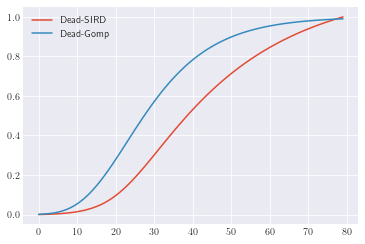

In [693]:
d_sird_norm = obj["y"][3, :] / obj["y"][3, :].max()
d_gomp = gomp_time(obj["t"], x0[c]/infl, *popt_gomp_country[c])
d_gomp_norm = d_gomp 
plt.plot(obj["t"], d_sird_norm, label="Dead-SIRD")
plt.plot(obj["t"], d_gomp_norm, label="Dead-Gomp")
# plt.plot(obj["t"], obj["y"][2, :], label="Recovered")
# plt.plot(obj["t"], obj["y"][0, :], label="Susceptible")
plt.legend()

0.30252905127969215 > 0.08192994161717765


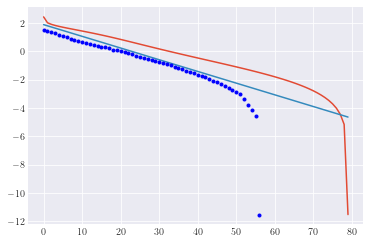

In [694]:
d_gomp_norm = gomp_time(obj["t"], x0[c]/infl, *popt_gomp_country[c])
plt.plot(obj["t"], safe_lnln(d_sird_norm))
plt.plot(obj["t"], np.log(- np.log(d_gomp)))
gamma, eta, beta = popt_country[c]
print(f"{gamma * eta} > {beta}")
plt.plot(t, ln, ".", color="#0000ff")